In [1]:
from trout.stars import get_star 
from trout.nights.year_nights import get_nights_in_a_year
from trout.nights import bad_nights

import numpy as np
import matplotlib.pyplot as plt

## Consecutive nights functions  

In [12]:
def get_consecutive_nights(start_year,end_year): 
    list_of_consecutive_nights = []
    bad_nights_date = [x[1] for x in bad_nights()] # Get the dates from the bad_nights() function 
    
    for i in range(end_year-start_year+1): 
        yearly_nights = get_nights_in_a_year(start_year+i) # Get all the nights for a year
        
        for index in range(len(yearly_nights)-1): 
            if ((yearly_nights[index+1]-yearly_nights[index]).days == 1 # Consecutive nights only 
                and (yearly_nights[index] not in bad_nights_date) 
                and  (yearly_nights[index+1] not in bad_nights_date)): # Filter out any consecutive night that is bad 
                list_of_consecutive_nights.append([yearly_nights[index],yearly_nights[index+1]])
                
    return np.array(list_of_consecutive_nights)

In [3]:
def signal_for_consecutive_dates(date_pair, star): # Return a list of two signals for a star for the pair of consecutive nights
    date_1, date_2 = date_pair
    star_data = get_star(star)
    selected_data_1 = (star_data.select(f"date = '{date_1}'")).selected_data
    selected_data_2 = (star_data.select(f"date = '{date_2}'")).selected_data
    
    if len(selected_data_1) != 0 and len(selected_data_2) != 0: # Only use signals if the star is present in BOTH nights
        return [selected_data_1[0][1], selected_data_2[0][1]]

In [4]:
def consecutive_nights_differences(start_year, end_year, star): # Return a list of signal differences between all consecutive nights
    nights = get_consecutive_nights(start_year, end_year)
    night_differences = [signal_for_consecutive_dates(date_pair, star) for date_pair in nights]
    night_differences = list(filter(lambda item: item is not None, night_differences)) # Filter out None values for absent nights
    differences = np.diff(night_differences, axis = 1) # Take the difference between the two signals
    
    return differences[:,0]

## Long-term variance function 

In [5]:
def get_long_term_variance(start_year, end_year, star): # Return the signal variance for all nights excluding bad nights for a star
    stars = get_star(star).select(f"date >= '{start_year}-01-01' and date < '{end_year+1}-01-01'")
    star_signal = stars.get_selected_data_column()
    variance = np.var(star_signal)
    return variance

In [32]:
np.sqrt(get_long_term_variance(2019, 2019, 2))

12399.876015821943

## Short-term variance function 

In [6]:
def get_short_term_variance(start_year, end_year, star): # Return the signal variance for all the consecutive nights differences for a star
    differences = consecutive_nights_differences(start_year, end_year, star)
    variance = np.var(differences)
    return variance

In [22]:
np.sqrt(get_short_term_variance(2020, 2020, 2))

19151.517230885336

## F-value function 

In [7]:
# Return the list of f values for stars
# f value for a star is calculated as (long term variance) / (short term variance) for that star
def f_value(start_year, end_year, from_star, to_star):
    f_values = []
    
    for star_range in range(to_star - from_star + 1): 
        star_no = from_star + star_range
        
        if (get_star(star_no)).attendance(start_year, end_year) > 0.5: # Only use stars with more than 50% night attendance
            long_term_variance = get_long_term_variance(start_year, end_year, star_no)
            short_term_variance = get_short_term_variance(start_year, end_year, star_no)
            f = long_term_variance/short_term_variance
            f_values.append([f, star_no])
            
    return np.array(f_values)

## F-stat functions

In [8]:
# Return a list of f-stat values for stars
# f stat values for a star is calculated as [(star's f value) - (average f value)] / (standard deviation from list of f values)
# Also prints out stars with f-stats > 3.0 
def f_stat(start_year, end_year, from_star, to_star): 
    f_stats = []
    potential_LPV = []
    f_keys = f_value(start_year, end_year, from_star, to_star)
    f_values = f_keys[:,0]
    mean = np.mean(f_values)
    std = np.std(f_values)
    
    for index in f_keys: 
        f_star = index[0]
        star = index[1] 
        f_stat = (f_star - mean)/std
        f_stats.append(f_stat)
        if f_stat > 3: 
            potential_LPV.append([star, f_stat])
            
    print("Here are the potential LPV with f-stat >= 4.75", [x for x in potential_LPV if x[0]>=4.75])
    print("Here are the potential LPV with f-stat 3 - 4.75", [x for x in potential_LPV if x[0]<4.75 and x[0] > 3])
    
    return f_stats

In [16]:
def hist_plot(data, star_from, star_to): # Plot the histogram for the f-stat values
    plt.figure(figsize=(4,3))
    n, bins, patches = plt.hist(data, bins='auto', color='#0504aa',
                            alpha=0.7)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('F-Stat Value')
    plt.ylabel('Count')
    plt.title(f'F-Test for stars {star_from}-{star_to}')
    plt.show()

In [19]:
data = f_stat(2012, 2016, 400, 573)

Here are the potential LPV with f-stat >= 4.75 [[414.0, 5.459129044962576], [533.0, 7.519353815528936]]
Here are the potential LPV with f-stat 3 - 4.75 []


[-0.42463369 -0.32760302 -0.23057234 -0.13354167 -0.03651099  0.06051968
  0.15755036  0.25458103  0.35161171  0.44864239  0.54567306  0.64270374
  0.73973441  0.83676509  0.93379576  1.03082644  1.12785711  1.22488779
  1.32191846  1.41894914  1.51597981  1.61301049  1.71004117  1.80707184
  1.90410252  2.00113319  2.09816387  2.19519454  2.29222522  2.38925589
  2.48628657  2.58331724  2.68034792  2.7773786   2.87440927  2.97143995
  3.06847062  3.1655013   3.26253197  3.35956265  3.45659332  3.553624
  3.65065467  3.74768535  3.84471602  3.9417467   4.03877738  4.13580805
  4.23283873  4.3298694   4.42690008  4.52393075  4.62096143  4.7179921
  4.81502278  4.91205345  5.00908413  5.10611481  5.20314548  5.30017616
  5.39720683  5.49423751  5.59126818  5.68829886  5.78532953  5.88236021
  5.97939088  6.07642156  6.17345223  6.27048291  6.36751359  6.46454426
  6.56157494  6.65860561  6.75563629  6.85266696  6.94969764  7.04672831
  7.14375899  7.24078966  7.33782034  7.43485102  7.53

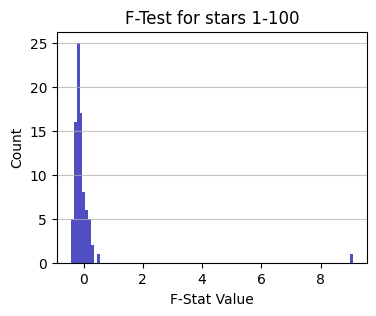

In [17]:
hist_plot(data, 400, 573)